In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#import cPickle as pkl
from sklearn.datasets import make_moons, make_blobs
from sklearn.decomposition import PCA

from flip_gradient import flip_gradient
from utils import *

Make a blob dataset. Dark vs. light colors distinguish domain and redish vs bluish colors distinguish class.

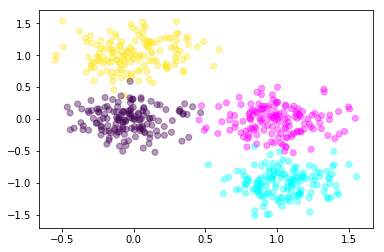

In [2]:
Xs, ys = make_blobs(300, centers=[[0, 0], [0, 1]], cluster_std=0.2)
Xt, yt = make_blobs(300, centers=[[1, -1], [1, 0]], cluster_std=0.2)

plt.scatter(Xs[:,0], Xs[:,1], c=ys, alpha=0.4)
plt.scatter(Xt[:,0], Xt[:,1], c=yt, cmap='cool', alpha=0.4)


In [3]:
batch_size = 16

def build_model(shallow_domain_classifier=True):
    X = tf.placeholder(tf.float32, [None, 2], name='X') # Input data
    Y_ind = tf.placeholder(tf.int32, [None], name='Y_ind')  # Class index
    D_ind = tf.placeholder(tf.int32, [None], name='D_ind')  # Domain index
    train = tf.placeholder(tf.bool, [], name='train')       # Switch for routing data to class predictor
    l = tf.placeholder(tf.float32, [], name='l')        # Gradient reversal scaler

    Y = tf.one_hot(Y_ind, 2)
    D = tf.one_hot(D_ind, 2)

    # Feature extractor - single layer
    W0 = weight_variable([2, 15])
    b0 = bias_variable([15])
    F = tf.nn.relu(tf.matmul(X, W0) + b0, name='feature')

    # Label predictor - single layer
    f = tf.cond(train, lambda: tf.slice(F, [0, 0], [batch_size // 2, -1]), lambda: F)
    y = tf.cond(train, lambda: tf.slice(Y, [0, 0], [batch_size // 2, -1]), lambda: Y)

    W1 = weight_variable([15, 2])
    b1 = bias_variable([2])
    p_logit = tf.matmul(f, W1) + b1
    p = tf.nn.softmax(p_logit)
    p_loss = tf.nn.softmax_cross_entropy_with_logits(logits = p_logit, labels = y)

    # Domain predictor - shallow
    f_ = flip_gradient(F, l)

    if shallow_domain_classifier:
        W2 = weight_variable([15, 2])
        b2 = bias_variable([2])
        d_logit = tf.matmul(f_, W2) + b2
        d = tf.nn.softmax(d_logit)
        d_loss = tf.nn.softmax_cross_entropy_with_logits(logits = d_logit, labels = D)

    else:
        W2 = weight_variable([15, 8])
        b2 = bias_variable([8])
        h2 = tf.nn.relu(tf.matmul(f_, W2) + b2)

        W3 = weight_variable([8, 2])
        b3 = bias_variable([2])
        d_logit = tf.matmul(h2, W3) + b3
        d = tf.nn.softmax(d_logit)
        d_loss = tf.nn.softmax_cross_entropy_with_logits(logits = d_logit, labels = D)


    # Optimization
    pred_loss = tf.reduce_sum(p_loss, name='pred_loss')
    domain_loss = tf.reduce_sum(d_loss, name='domain_loss')
    total_loss = tf.add(pred_loss, domain_loss, name='total_loss')

    pred_train_op = tf.train.AdamOptimizer(0.01).minimize(pred_loss, name='pred_train_op')
    domain_train_op = tf.train.AdamOptimizer(0.01).minimize(domain_loss, name='domain_train_op')
    dann_train_op = tf.train.AdamOptimizer(0.01).minimize(total_loss, name='dann_train_op')

    # Evaluation
    p_acc = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(y, 1), tf.arg_max(p, 1)), tf.float32), name='p_acc')
    d_acc = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(D, 1), tf.arg_max(d, 1)), tf.float32), name='d_acc')

In [4]:
build_model()
sess = tf.InteractiveSession()

def train_and_evaluate(sess, train_op_name, train_loss_name, grad_scale=None, num_batches=10000, verbose=True):
    # Create batch builders
    S_batches = batch_generator([Xs, ys], batch_size // 2)
    T_batches = batch_generator([Xt, yt], batch_size // 2)
    
    # Get output tensors and train op
    d_acc = sess.graph.get_tensor_by_name('d_acc:0')
    p_acc = sess.graph.get_tensor_by_name('p_acc:0')
    train_loss = sess.graph.get_tensor_by_name(train_loss_name + ':0')
    train_op = sess.graph.get_operation_by_name(train_op_name)
    
    sess.run(tf.global_variables_initializer())
    for i in range(num_batches):

        # If no grad_scale, use a schedule
        if grad_scale is None:
            p = float(i) / num_batches
            lp = 2. / (1. + np.exp(-10. * p)) - 1
        else:
            lp = grad_scale

        X0, y0 = S_batches.__next__()
        X1, y1 = T_batches.__next__()
        Xb = np.vstack([X0, X1])
        yb = np.hstack([y0, y1])
        D_labels = np.hstack([np.zeros(batch_size // 2, dtype=np.int32),
                              np.ones(batch_size // 2, dtype=np.int32)])

        _, loss, da, pa = sess.run([train_op, train_loss, d_acc, p_acc],
                                   feed_dict={'X:0': Xb, 'Y_ind:0': yb, 'D_ind:0': D_labels,
                                              'train:0': True, 'l:0': lp})

        if verbose and i % 200 == 0:
            print ('loss: %f, domain accuracy: %f, class accuracy: %f' % (loss, da, pa))

            
    # Get final accuracies on whole dataset
    das, pas = sess.run([d_acc, p_acc], feed_dict={'X:0': Xs, 'Y_ind:0': ys, 
                            'D_ind:0': np.zeros(Xs.shape[0], dtype=np.int32), 'train:0': False, 'l:0': 1.0})
    dat, pat = sess.run([d_acc, p_acc], feed_dict={'X:0': Xt, 'Y_ind:0': yt,
                            'D_ind:0': np.ones(Xt.shape[0], dtype=np.int32), 'train:0': False, 'l:0': 1.0})

    print ('Source domain: ', das)
    print ('Source class: ', pas)
    print ('Target domain: ', dat)
    print ('Target class: ', pat)


def extract_and_plot_pca_feats(sess, feat_tensor_name='feature'):
    F = sess.graph.get_tensor_by_name(feat_tensor_name + ':0')
    emb_s = sess.run(F, feed_dict={'X:0': Xs})
    emb_t = sess.run(F, feed_dict={'X:0': Xt})
    emb_all = np.vstack([emb_s, emb_t])

    pca = PCA(n_components=2)
    pca_emb = pca.fit_transform(emb_all)

    num = pca_emb.shape[0] // 2
    plt.scatter(pca_emb[:num,0], pca_emb[:num,1], c=ys, alpha=0.4)
    plt.scatter(pca_emb[num:,0], pca_emb[num:,1], c=yt, cmap='cool', alpha=0.4)

#### Domain classification

Setting `grad_scale=-1.0` effectively turns off the gradient reversal. Training just the domain classifier creates representation that collapses classes.

Source domain:  1.0
Source class:  0.496667
Target domain:  0.996667
Target class:  0.5


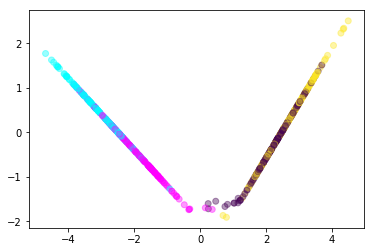

In [5]:
train_and_evaluate(sess, 'domain_train_op', 'domain_loss', grad_scale=-1.0, verbose=False)
extract_and_plot_pca_feats(sess)

#### Label classification

Training label prediction in the source domain results in poor adapatation to the target. (1) The representation separates the classes in the source domain, but fails to separate the classes of the target domain. (2) The representation shows significant separation of classes.

Source domain:  1.0
Source class:  0.993333
Target domain:  0.0
Target class:  0.5


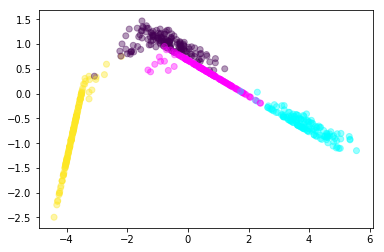

In [6]:
train_and_evaluate(sess, 'pred_train_op', 'pred_loss', verbose=False)
extract_and_plot_pca_feats(sess)

#### Domain adaptation

Training with domain adversarial loss results in much better transfer to the target. The domains can usually still be distinguished in repeated experiments.

Source domain:  0.55
Source class:  0.98
Target domain:  0.53
Target class:  0.903333


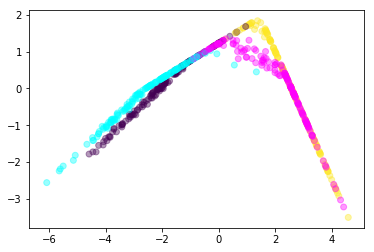

In [7]:
train_and_evaluate(sess, 'dann_train_op', 'total_loss', verbose=False)
extract_and_plot_pca_feats(sess)

#### Domain adaptation - deeper domain classifier

Using a domain classifier that is deeper seems to more reliably collapse the domains on this problem in repeated experiments.

Source domain:  1.0
Source class:  0.986667
Target domain:  0.0
Target class:  0.79


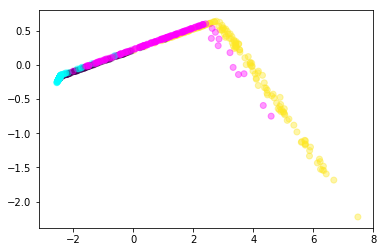

In [8]:
sess.close()
tf.reset_default_graph()
build_model(False)
sess = tf.InteractiveSession()

train_and_evaluate(sess, 'dann_train_op', 'total_loss', verbose=False)
extract_and_plot_pca_feats(sess)